# 7.5 - Sınıflandırma Problemler: Sınıf Dengesizliği
Sınıf dengesizliğine sahip kalp krizi riski'ne ilişkin veri kümesini kullanarak:

* Lojistik Regresyon modeli oluşturup modelinizin performansını ölçün,
* Değişik yöntemler ve sınıf oranlarını deneyerek, sınıf dengesizliğinin üstesinden gelin ve performansı en yüksek yöntemi ve sınıflar arası oranı belirleyin.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings; warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

title_font = {"family":"arial", "color":"black", "weight":"bold", "size":16}
axis_font = {"family":"serif", "color":"gray", "weight":"normal", "size":14}

#train_data = pd.read_csv("titanic_train.csv")
#test_data = pd.read_csv("titanic_test.csv")

train_data = pd.read_csv("cleveland.csv")

In [2]:
# train data
train_data.head(6)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,negative
1,37,1,3,130,250,0,0,187,0,3.5,3,0,3,negative
2,41,0,2,130,204,0,2,172,0,1.4,1,0,3,negative
3,56,1,2,120,236,0,0,178,0,0.8,1,0,3,negative
4,57,0,4,120,354,0,0,163,1,0.6,1,0,3,negative
5,57,1,4,140,192,0,0,148,0,0.4,2,0,6,negative


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       177 non-null    int64  
 1   sex       177 non-null    int64  
 2   cp        177 non-null    int64  
 3   trestbps  177 non-null    int64  
 4   chol      177 non-null    int64  
 5   fbs       177 non-null    int64  
 6   restecg   177 non-null    int64  
 7   thalach   177 non-null    int64  
 8   exang     177 non-null    int64  
 9   oldpeak   177 non-null    float64
 10  slope     177 non-null    int64  
 11  ca        177 non-null    object 
 12  thal      177 non-null    object 
 13  num       177 non-null    object 
dtypes: float64(1), int64(10), object(3)
memory usage: 19.5+ KB


In [4]:
# tipleri "object" olan değişkenleri kontrol etmekte fayda var.
for i in ["ca", "thal", "num"]:
    print(f"{i} sütununun değerleri:\n {train_data[i].unique()}\n")

ca sütununun değerleri:
 ['0' '2' '1' '3' '<null>']

thal sütununun değerleri:
 ['6' '3' '7' '<null>']

num sütununun değerleri:
 ['negative' 'positive']



In [5]:
# ca sütunu boş değerleri
display(train_data[train_data.ca=="<null>"])
print("\n'ca' sütunundaki değerler ve sayıları:", train_data.ca.value_counts(), sep="\n")

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
85,52,1,3,138,223,0,0,169,0,0.0,1,<null>,3,negative
142,58,1,2,125,220,0,0,144,0,0.4,2,<null>,7,negative
146,38,1,3,138,175,0,0,173,0,0.0,1,<null>,3,negative



'ca' sütunundaki değerler ve sayıları:
0         133
1          24
2           9
3           8
<null>      3
Name: ca, dtype: int64


In [6]:
# thal sütunu boş değerleri
train_data[train_data.thal=="<null>"]
print("\n'thal' sütunundaki değerler ve sayıları:", train_data.thal.value_counts(), sep="\n")


'thal' sütunundaki değerler ve sayıları:
3         131
7          37
6           8
<null>      1
Name: thal, dtype: int64


Değişkenlerdeki \<null> değerleri o sütundaki en kalabalık sayıya dönüştürüp diğer sütunlarla olan korelasyonuna bakalım.
<br>Sonra tekrardan dönüp -tabii gerekirse- korelasyonda olduğu değişkenleri inceleyerek daha uygun bir değer belirleyebiliriz.<br> Ayrıca "num" değişkenindeki değerleri ("negatif" ve "pozitif") de 0 ve 1 olarak ikili değerlere dönüştürmemiz daha uygun olacaktır.

In [7]:
train_data.ca = train_data.ca.replace("<null>", 0)
train_data.thal = train_data.thal.replace("<null>", 3)
train_data.num = train_data.num.replace("negative", 0)
train_data.num = train_data.num.replace("positive", 1)

train_data.ca = train_data.ca.astype("int64")
train_data.thal = train_data.thal.astype("int64")
train_data.num = train_data.num.astype("int64")

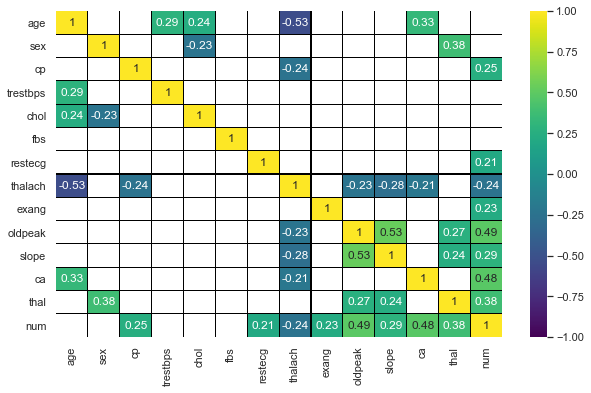

In [8]:
cor_data = train_data.corr()
sns.heatmap(cor_data[abs(cor_data)>0.2], annot=True, linecolor="black",
            linewidths=0.1, vmin=-1, vmax=1, cmap="viridis")
plt.show()

In [9]:
# Bağımlı değişkenimizin dağılımı
sifir_yuzdelik = train_data.num.value_counts()[0]/len(train_data.num)
print(f"0 olan değerlerin yüzdesi: %{(100*sifir_yuzdelik):.2f}")
print(f"1 olan değerlerin yüzdesi: %{(100*(1-sifir_yuzdelik)):.2f}")
del sifir_yuzdelik

0 olan değerlerin yüzdesi: %92.66
1 olan değerlerin yüzdesi: %7.34


# Lojistik Regresyon Modeli Parametreleri:

In [10]:
# Modelimizin bağımsız ve bağımlı değişkenlerini tanımlayalım.
X = train_data.iloc[:, :-1]
Y = train_data.iloc[:, 1]

In [11]:
%%time
# grid search

import warnings
warnings.filterwarnings("ignore")

def LR_model(x, y):
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, 
                                                        test_size=0.20, 
                                                        random_state=42, 
                                                        stratify = y
                                                       )
    global grid_cv
    log_reg = LogisticRegression(solver="saga", max_iter=2000)

    parameters = {"C": np.logspace(-5, 5, 15), 
                  "penalty": ["l1", 'l2'], 
                  #"multi_class":["ovr", "multinomial"], 
                  #"solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"], 
                 }

    grid_cv = GridSearchCV(estimator = log_reg,
                           param_grid = parameters,
                           cv = 10)
    grid_cv.fit(x, y)
        
    grid_results = grid_cv.cv_results_
    grid_df = pd.DataFrame(grid_results)
    grid_df = grid_df[['param_penalty','param_C', 'mean_test_score']]
    grid_df = grid_df.sort_values(by='mean_test_score', ascending = False)
    display(grid_df)
    
    print("\n", "-" * 8, "Classification Report", "-" * 8)
    train_predict = grid_cv.predict(X_train)
    test_predict = grid_cv.predict(X_test)
    print("Eğitim Seti:\n", classification_report(Y_train, train_predict))
    print("Test Seti:\n", classification_report(Y_test, test_predict))
    
    #print("En iyi parametreler : ", grid_cv.best_params_)
    #print(f"En iyi skor         : {grid_cv.best_score_:.4f}\n")

LR_model(X, Y)

,param_penalty,param_C,mean_test_score
15,l2,1,0.808497
16,l1,5.17947,0.808497
28,l1,100000,0.808497
27,l2,19307,0.808497
26,l1,19307,0.808497
25,l2,3727.59,0.808497
24,l1,3727.59,0.808497
23,l2,719.686,0.808497
22,l1,719.686,0.808497
21,l2,138.95,0.808497



 -------- Classification Report --------
Eğitim Seti:
               precision    recall  f1-score   support

           0       0.80      0.69      0.75        59
           1       0.80      0.88      0.84        82

    accuracy                           0.80       141
   macro avg       0.80      0.79      0.79       141
weighted avg       0.80      0.80      0.80       141

Test Seti:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.83      0.95      0.89        21

    accuracy                           0.86        36
   macro avg       0.88      0.84      0.85        36
weighted avg       0.87      0.86      0.86        36

Wall time: 11.4 s


# Örneklem Arttırma

In [12]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN

In [13]:
# şu anki veri durumu
train_data.num.value_counts()

0    164
1     13
Name: num, dtype: int64

In [14]:
# pozitif sayısını da negatife çekerek deneme yapalım
negatif = train_data[train_data.num == 0]
pozitif = train_data[train_data.num == 1]

pozitif_arttirilmis = resample(pozitif, replace = True, 
                               n_samples = len(negatif), random_state = 42)

resample_df = pd.concat([negatif, pozitif_arttirilmis])
resample_df.num.value_counts()

1    164
0    164
Name: num, dtype: int64

In [15]:
X_resample = resample_df.iloc[:, :-1]
Y_resample = resample_df.iloc[:, 1]
print("-"*10, "Resample Sonuçları", "-"*10, end="")
LR_model(X_resample, Y_resample)

---------- Resample Sonuçları ----------

,param_penalty,param_C,mean_test_score
12,l1,0.19307,0.801326
15,l2,1,0.795265
16,l1,5.17947,0.795265
28,l1,100000,0.795265
27,l2,19307,0.795265
26,l1,19307,0.795265
25,l2,3727.59,0.795265
24,l1,3727.59,0.795265
23,l2,719.686,0.795265
22,l1,719.686,0.795265



 -------- Classification Report --------
Eğitim Seti:
               precision    recall  f1-score   support

           0       0.87      0.58      0.70        77
           1       0.85      0.96      0.90       185

    accuracy                           0.85       262
   macro avg       0.86      0.77      0.80       262
weighted avg       0.85      0.85      0.84       262

Test Seti:
               precision    recall  f1-score   support

           0       0.89      0.42      0.57        19
           1       0.81      0.98      0.88        47

    accuracy                           0.82        66
   macro avg       0.85      0.70      0.73        66
weighted avg       0.83      0.82      0.79        66



In [16]:
smote_model = SMOTE(sampling_strategy = 1, random_state = 42)

X_smote, Y_smote = smote_model.fit_sample(X, Y)
print("-" * 10, "SMOTE Sonuçları", "-" * 10, end="")
LR_model(X_smote, Y_smote)

---------- SMOTE Sonuçları ----------

,param_penalty,param_C,mean_test_score
15,l2,1,0.782143
16,l1,5.17947,0.782143
28,l1,100000,0.782143
27,l2,19307,0.782143
26,l1,19307,0.782143
25,l2,3727.59,0.782143
24,l1,3727.59,0.782143
23,l2,719.686,0.782143
22,l1,719.686,0.782143
21,l2,138.95,0.782143



 -------- Classification Report --------
Eğitim Seti:
               precision    recall  f1-score   support

           0       0.81      0.82      0.81        82
           1       0.81      0.80      0.81        82

    accuracy                           0.81       164
   macro avg       0.81      0.81      0.81       164
weighted avg       0.81      0.81      0.81       164

Test Seti:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79        21
           1       0.80      0.76      0.78        21

    accuracy                           0.79        42
   macro avg       0.79      0.79      0.79        42
weighted avg       0.79      0.79      0.79        42



In [17]:
adasyn_model = ADASYN(sampling_strategy = "auto", random_state = 42)

X_adasyn, y_adasyn = adasyn_model.fit_sample(X, Y)
print("-" * 10, "ADASYN Sonuçları", "-" * 10, end="")
LR_model(X_adasyn, y_adasyn)

---------- ADASYN Sonuçları ----------

,param_penalty,param_C,mean_test_score
14,l1,1,0.777105
15,l2,1,0.777105
16,l1,5.17947,0.777105
28,l1,100000,0.777105
27,l2,19307,0.777105
26,l1,19307,0.777105
25,l2,3727.59,0.777105
24,l1,3727.59,0.777105
23,l2,719.686,0.777105
22,l1,719.686,0.777105



 -------- Classification Report --------
Eğitim Seti:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77        76
           1       0.78      0.79      0.79        82

    accuracy                           0.78       158
   macro avg       0.78      0.78      0.78       158
weighted avg       0.78      0.78      0.78       158

Test Seti:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78        19
           1       0.78      0.86      0.82        21

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40

